In [2]:
import datetime as dt
import math
import keras
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [3]:
df=pd.read_csv("TSLA.csv")
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (1259, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


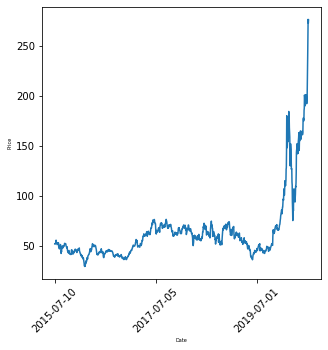

In [20]:
plt.figure(figsize = (5,5))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=5)
plt.ylabel('Price',fontsize=5)
plt.show()

### The target value to be predicted is going to be the “Close” stock price value.

In [4]:
training_set = df.iloc[:800, 1:2].values
test_set = df.iloc[800:, 1:2].values

### Reshaping the data into the following format (values, time-steps, 1 dimensional output)

In [5]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)

###  We will build the LSTM with 50 neurons and 4 hidden layers. Finally, we will assign 1 neuron in the output layer for predicting the normalized stock price. We will use the MSE loss function and the Adam stochastic gradient descent optimizer

In [10]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
24/24 [==============================] - 10s 123ms/step - loss: 0.0799
Epoch 2/100
24/24 [==============================] - 3s 129ms/step - loss: 0.0181
Epoch 3/100
24/24 [==============================] - 3s 134ms/step - loss: 0.0139
Epoch 4/100
24/24 [==============================] - 5s 222ms/step - loss: 0.0131
Epoch 5/100
24/24 [==============================] - 6s 252ms/step - loss: 0.0117
Epoch 6/100
24/24 [==============================] - 6s 252ms/step - loss: 0.0121
Epoch 7/100
24/24 [==============================] - 5s 227ms/step - loss: 0.0116
Epoch 8/100
24/24 [==============================] - 5s 206ms/step - loss: 0.0121
Epoch 9/100
24/24 [==============================] - 3s 129ms/step - loss: 0.0113
Epoch 10/100
24/24 [==============================] - 3s 123ms/step - loss: 0.0117
Epoch 11/100
24/24 [==============================] - 3s 125ms/step - loss: 0.0098
Epoch 12/100
24/24 [==============================] - 3s 127ms/step - loss: 0.0096
Epoch 13/100

### Prepare the test data (reshape them)

In [12]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(459, 60, 1)


### Make Predictions using the test set

In [13]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

## Huge drop in March 2020 due to the COVID-19 lockdown

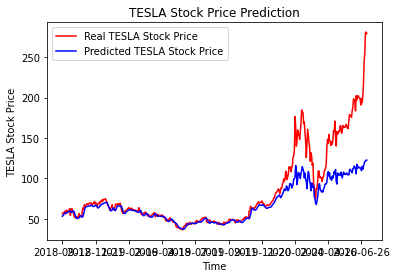

In [14]:
# Visualising the results
plt.plot(df.loc[800:, 'Date'],dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[800:, 'Date'],predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

In [32]:
### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(dataset_test.values, predicted_stock_price))

31.179132799381673